In [40]:
import pandas as pd
import numpy as np

from typing import List, Tuple, Union, Dict

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import geocoder


In [41]:
class Config:
    train_path = "../input/train_v2.csv"
    test_path = "../input/test_v2.csv"
    sample_submission_path = "../input/sample_submission.csv"
    output_path = "../submission/"
    seed = 42
    n_splits = 2


In [42]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)


In [43]:
# 参考
# https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



In [44]:
# https://comp.probspace.com/competitions/pollen_counts/discussions/tanuking0-Post352b748b3b6d376b837e
#＊ 花粉飛散量に関する補足 (2022/11/15追記)
# 空白, -9996,-9997,-9998については下記を表しています
# -9998:降雪による欠測
# -9997:黄砂による欠測
# -9996:その他の欠測(前後の時間や周辺観測値と比較して不自然なデータ)
# 空白:未観測または通信障害による欠測


#df_train.loc[df_train["pollen_utsunomiya"] < 0, "pollen_utsunomiya"] = '欠測'
#df_train.loc[df_train["pollen_chiba"] < 0, "pollen_chiba"] = '欠測'
#df_train.loc[df_train["pollen_tokyo"] < 0, "pollen_tokyo"] = '欠測'

#df_train.loc[df_train["pollen_utsunomiya"] < 0, "pollen_utsunomiya"] = 0
#df_train.loc[df_train["pollen_chiba"] < 0, "pollen_chiba"] = 0
#df_train.loc[df_train["pollen_tokyo"] < 0, "pollen_tokyo"] = 0

# 雪は花粉０そうなので0
df_train.loc[df_train["pollen_utsunomiya"] == -9998, "pollen_utsunomiya"] = 0
df_train.loc[df_train["pollen_chiba"] == -9998, "pollen_chiba"] = 0
df_train.loc[df_train["pollen_tokyo"] == -9998, "pollen_tokyo"] = 0

# 黄砂は花粉飛びそうだがいったん 0
#df_train.loc[df_train["pollen_utsunomiya"] == -9997, "pollen_utsunomiya"] = '欠測'
#df_train.loc[df_train["pollen_chiba"] == -9997, "pollen_chiba"] = '欠測'
#df_train.loc[df_train["pollen_tokyo"] == -9997, "pollen_tokyo"] = '欠測'

# -9996 は削除、後段で実施
# 空白はたぶんない

In [49]:
df_train[df_train["pollen_tokyo"] %4 != 0]

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
15,2017020116,0.0,0.0,0.0,8.2,10.2,9.1,9,13,14,2.2,3.4,1.6,32.0,16.0,49.0
16,2017020117,0.0,0.0,0.0,7.3,10.0,8.2,11,14,0,3.9,2.5,0.2,20.0,28.0,61.0
17,2017020118,0.0,0.0,0.0,5.9,9.2,6.3,10,13,14,4.8,1.0,0.5,4.0,28.0,73.0
18,2017020119,0.0,0.0,0.0,4.9,9.2,3.9,11,14,0,4.7,2.8,0.0,20.0,24.0,86.0
19,2017020120,0.0,0.0,0.0,4.2,8.4,5.3,1,14,13,5.4,1.3,0.9,483.0,16.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12130,2020032711,0.0,0.0,0,15.4,18.2,20.3,9,10,7,3.8,8.9,3.8,36.0,28.0,61.0
12131,2020032712,0.0,0.0,0,16.9,18,21.8,8,10,9,3.3,12.6,7.2,24.0,8.0,53.0
12154,2020032811,0.0,0.0,0,21.9,18.6,21.7,3,12,13,3.0,3.8,1.1,139.0,4.0,49.0
12155,2020032812,0.0,0.0,0,18.9,19.4,22,4,12,12,6.7,3.9,0.8,106.0,8.0,57.0


In [6]:
def remove_spike(df, cols=["pollen_tokyo", "pollen_utsunomiya", "pollen_chiba"], 
                 th=3, span=24):
    
    _df = df.copy()
    for col in cols:
        ewm_mean = _df[col].ewm(span=span).mean()
        ewm_std = _df[col].ewm(span=span).std()
        
        #_df.loc[(_df[col] - ewm_mean).abs() > ewm_std * th, col] = np.nan
        print(_df.loc[(_df[col] - ewm_mean) > ewm_std * th, "datetime"].shape)
        _df.loc[(_df[col] - ewm_mean) > ewm_std * th, col] = np.nan
        
    return _df

df_train = remove_spike(df_train)

(33,)
(45,)
(34,)


In [7]:
df_train = df_train.replace("欠測", np.nan)
lgb_imp = IterativeImputer(
    estimator=LGBMRegressor(num_boost_round=1000, random_state=Config.seed),
    max_iter=10,
    initial_strategy="mean",
    imputation_order="ascending",
    verbose=1,
    random_state=Config.seed,
)

df_train = pd.DataFrame(lgb_imp.fit_transform(df_train), columns=df_train.columns)


[IterativeImputer] Completing matrix with shape (12240, 16)
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will 

[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[IterativeImputer] Change: 1828.88151475584, scaled tolerance: 2020033.124 
[IterativeImputer] Early stopping criterion reached.


In [8]:
df_train[df_train["pollen_utsunomiya"] < 0 ].head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
198,2.017021e+09,0.0,0.5,0.0,0.7,1.7,0.9,3.0,2.0,1.0,1.1,4.6,1.3,-1747.051010,0.0,295.0
199,2.017021e+09,0.0,0.0,0.0,0.3,2.2,1.0,16.0,15.0,1.0,3.1,3.6,1.2,-9996.000000,0.0,344.0
200,2.017021e+09,0.0,0.0,0.0,-0.3,2.8,1.8,1.0,15.0,1.0,4.2,2.9,0.8,-9996.000000,0.0,4.0
3863,2.018021e+09,0.0,0.0,0.0,2.4,4.7,3.0,8.0,15.0,16.0,2.0,5.4,0.9,-0.570227,4.0,4.0
4101,2.018022e+09,0.0,0.0,0.0,1.5,5.5,5.5,15.0,3.0,5.0,4.8,3.9,1.4,-14.573209,28.0,0.0


In [9]:
# 型がfloatになってしまっているので、もどす。
df_train[["winddirection_chiba", "winddirection_tokyo"]] = (
    df_train[["winddirection_chiba", "winddirection_tokyo"]].round().astype(int)
)
df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
] = df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
].round(
    1
)
df_train["datetime"] = df_train["datetime"].astype(int)

# df_train[df_train.select_dtypes(object).columns] = df_train[df_train.select_dtypes(object).columns]
df_train.head(3)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,4.0,1.7,0.6,4.0,32.0,12.0


In [10]:
loc_list = ["宇都宮市中央生涯学習センター", "千葉県環境研究センター", "東京都多摩小平保健所"]

utsunomiya = "utsunomiya"
chiba = "chiba"
tokyo = "tokyo"

key_list = [utsunomiya, chiba, tokyo]

LATLNG_DICT = {}

try:

    for i, key in zip(loc_list, key_list):
        loc = geocoder.osm(i, timeout=5.0)
        print(loc.latlng)
        print(loc.address)
        LATLNG_DICT[key] = tuple(loc.latlng)

    LOC_VECTOR_DICT = {
        (utsunomiya, tokyo): np.array(LATLNG_DICT[utsunomiya])
        - np.array(LATLNG_DICT[tokyo]),
        (utsunomiya, chiba): np.array(LATLNG_DICT[utsunomiya])
        - np.array(LATLNG_DICT[chiba]),
        (chiba, tokyo): np.array(LATLNG_DICT[chiba]) - np.array(LATLNG_DICT[tokyo]),
        (chiba, utsunomiya): np.array(LATLNG_DICT[chiba])
        - np.array(LATLNG_DICT[utsunomiya]),
        (tokyo, chiba): np.array(LATLNG_DICT[tokyo]) - np.array(LATLNG_DICT[chiba]),
        (tokyo, utsunomiya): np.array(LATLNG_DICT[tokyo])
        - np.array(LATLNG_DICT[utsunomiya]),
    }

    print(LATLNG_DICT)
    print(LOC_VECTOR_DICT)

except Exception as e:
    print(e)
    print("APIでのデータ取得に失敗したため、成功時に取得したデータを使います。")
    LATLNG_DICT = {
        "utsunomiya": (36.5594462, 139.88265145),
        "chiba": (35.633642, 140.077749),
        "tokyo": (35.7298652, 139.51664115548698),
    }
    LOC_VECTOR_DICT = {
        ("utsunomiya", "tokyo"): np.array([0.829581, 0.36601029]),
        ("utsunomiya", "chiba"): np.array([0.9258042, -0.19509755]),
        ("chiba", "tokyo"): np.array([-0.0962232, 0.56110784]),
        ("chiba", "utsunomiya"): np.array([-0.9258042, 0.19509755]),
        ("tokyo", "chiba"): np.array([0.0962232, -0.56110784]),
        ("tokyo", "utsunomiya"): np.array([-0.829581, -0.36601029]),
    }


output = """
[36.5594462, 139.88265145]
宇都宮市 中央生涯学習センター, 中央通り, 中央一丁目, 宇都宮市, 栃木県, 320-0802, 日本
[35.633642, 140.077749]
千葉県環境研究センター, 海浜松風通り, 高浜五丁目, 美浜区, 千葉市, 千葉県, 261-0004, 日本
[35.7298652, 139.51664115548698]
東京都多摩小平保健所, 青梅街道, 芝久保町, 小平市, 東京都, 188-0014, 日本
{'utsunomiya': (36.5594462, 139.88265145), 'chiba': (35.633642, 140.077749), 'tokyo': (35.7298652, 139.51664115548698)}
{('utsunomiya', 'tokyo'): array([0.829581  , 0.36601029]), ('utsunomiya', 'chiba'): array([ 0.9258042 , -0.19509755]), ('chiba', 'tokyo'): array([-0.0962232 ,  0.56110784]), ('chiba', 'utsunomiya'): array([-0.9258042 ,  0.19509755]), ('tokyo', 'chiba'): array([ 0.0962232 , -0.56110784]), ('tokyo', 'utsunomiya'): array([-0.829581  , -0.36601029])}
"""



[36.5594462, 139.88265145]
宇都宮市 中央生涯学習センター, 中央通り, 中央一丁目, 宇都宮市, 栃木県, 320-0802, 日本
[35.633642, 140.077749]
千葉県環境研究センター, 海浜松風通り, 高浜五丁目, 美浜区, 千葉市, 千葉県, 261-0004, 日本
[35.7298652, 139.51664115548698]
東京都多摩小平保健所, 青梅街道, 芝久保町, 小平市, 東京都, 188-0014, 日本
{'utsunomiya': (36.5594462, 139.88265145), 'chiba': (35.633642, 140.077749), 'tokyo': (35.7298652, 139.51664115548698)}
{('utsunomiya', 'tokyo'): array([0.829581  , 0.36601029]), ('utsunomiya', 'chiba'): array([ 0.9258042 , -0.19509755]), ('chiba', 'tokyo'): array([-0.0962232 ,  0.56110784]), ('chiba', 'utsunomiya'): array([-0.9258042 ,  0.19509755]), ('tokyo', 'chiba'): array([ 0.0962232 , -0.56110784]), ('tokyo', 'utsunomiya'): array([-0.829581  , -0.36601029])}


# Feature

In [11]:
import datetime
import re

# 時間
def to_datetime(time: datetime.datetime) -> datetime.datetime:
    time = str(time)
    try:
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
    except ValueError:
        time = re.sub("24$", "23", time)
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
        time += datetime.timedelta(hours=1)
    return time


def time_feat(df: pd.DataFrame) -> pd.DataFrame:
    df["datetime_dt"] = df["datetime"].apply(to_datetime)
    df["year"] = df["datetime_dt"].dt.year
    df["month"] = df["datetime_dt"].dt.month
    df["day"] = df["datetime_dt"].dt.day
    df["hour"] = df["datetime_dt"].dt.hour
    df["hour_sin"] = np.sin(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["hour_cos"] = np.cos(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["weekday"] = df["datetime_dt"].dt.weekday
    df["day_of_year"] = df["datetime_dt"].dt.dayofyear
    df["day_sin"] = np.sin(df["day_of_year"] * (2 * np.pi / (365 + 1)))
    df["day_cos"] = np.cos(df["day_of_year"] * (2 * np.pi / (365 + 1)))
    
    df["month_sin"] = np.sin(df["month"]  * (2 * np.pi / (12 + 1)))
    df["month_cos"] = np.cos(df["month"]  * (2 * np.pi / (12 + 1)))
    
    df["day_sin_sum_hour_sin"] = df["day_sin"] + df["hour_sin"]
    df["day_cos_sum_hour_cos"] = df["day_sin"] + df["hour_cos"]
    
    df["day_sin_sum_hour_sin_sum_month_sin"] = df["day_sin"] + df["hour_sin"] + df["month_sin"]
    df["day_cos_sum_hour_cos_sum_month_cos"] = df["day_sin"] + df["hour_cos"] + df["month_cos"]
    
    df["hour_sin_sum_month_sin"] = df["hour_sin"] + df["month_sin"]
    df["hour_cos_sum_month_cos"] = df["hour_cos"] + df["month_cos"]
    
    df["day_sin_mult_hour"] = df["day_sin"] * ( 1 + df["hour"] / 24)
    df["day_cos_mult_hour"] = df["day_cos"] * ( 1 + df["hour"] / 24)
    
    df["day_sin_mult_hour_mult_month"] = df["day_sin"] * ( 1 + df["hour"] / 24) * (1 + df["month"] / 13)
    df["day_cos_mult_hour_mult_month"] = df["day_cos"] * ( 1 + df["hour"] / 24) * (1 + df["month"] / 13)
    
#     df["day_sin_mulit_hour_sin"] = df["hour_sin"] * df["day_sin"] 
#     df["day_sin_mulit_hour_cos"] = df["hour_cos"] * df["day_cos"]
    
#     df["day_sin_sum_hour_sin"] = df["hour_sin"] + df["day_sin"] 
#     df["day_sin_sum_hour_cos"] = df["hour_cos"] + df["day_cos"]

#     df["day_sin_mulit_hour_sin_mult_month"] = df["hour_sin"] * df["day_sin"] * (df["month"] / 12)
#     df["day_sin_mulit_hour_cos_mult_month"] = df["hour_cos"] * df["day_cos"] * (df["month"] / 12)
    
#     df["day_sin_sum_hour_sin_mult_month"] = df["hour_sin"] + df["day_sin"] * (df["month"] / 12)
#     df["day_sin_sum_hour_cos_mult_month"] = df["hour_cos"] + df["day_cos"] * (df["month"] / 12)

    for col in ["temperature_tokyo", "temperature_utsunomiya", "temperature_chiba"]:

        df[f"month_sin_mult_temperature_{col}"] = df[col] * df["month_sin"]
        df[f"month_cos_mult_temperature_{col}"] = df[col] * df["month_cos"]
        
        df[f"day_sin_sum_hour_sin_sum_month_sin_mult_temperature_{col}"] = df[col] * df["day_sin_sum_hour_sin_sum_month_sin"]
        df[f"day_sin_sum_hour_sin_sum_month_sin_mult_temperature_{col}"] = df[col] * df["day_sin_sum_hour_sin_sum_month_sin"]

    return df


# ラグ特徴/ローリング特徴量
def add_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for lag in [1, 2, 3, 4, 5]:
        # shift
        outputs.append(grp_df[feat].shift(lag).add_prefix(f"shift{lag}_"))
        # diff
        outputs.append(grp_df[feat].diff(lag).add_prefix(f"diff{lag}_"))

    # rolling
    windows = [3] + [i * 24 for i in range(1, 10)]
    for window in windows:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))

    _df = pd.concat(outputs, axis=1)
    return _df


# 未来のローリング -> 下がったのでなし
# https://www.slideshare.net/TakanoriHayashi3/talkingdata-adtracking-fraud-detection-challenge-1st-place-solution
def add_future_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]
    grp_df = df.iloc[::-1].groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for window in [3, 24]:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"future_rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))
    return pd.concat(outputs, axis=1)


def add_lag_feat_one_year(df: pd.DataFrame, feat: List[str]) -> pd.DataFrame:
    outputs = [df]
    prefix = "shift_one_year_"
    outputs.append(df[feat].shift(3600).add_prefix(prefix))

    df = pd.concat(outputs, axis=1)
    outputs = [df]
    cols = [f"{prefix}{col}" for col in feat]
    
    for window in [3] + [i * 24 for i in range(1, 10)]:
        outputs.append(
            df[cols].rolling(window, min_periods=1).mean().add_prefix(f"roll_{window}_")
        )

    df = pd.concat(outputs, axis=1)
    return df


# 集計特徴
def additional_encoding(
    train: pd.DataFrame, test: pd.DataFrame, cat_col: List[str], num_col: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    trdf = train.copy()
    tedf = test.copy()

    # Count Encoding
    for ccol in cat_col:
        encoder = trdf[(trdf["month"] == 4) & (trdf["day"] < 15)][ccol].value_counts()
        trdf[f"ce_{ccol}"] = trdf[ccol].map(encoder)
        tedf[f"ce_{ccol}"] = tedf[ccol].map(encoder)

    # Add Aggregate Features
    agg_cols = ["mean", "std", "min", "max"]
    for ccol in cat_col:
        for ncol in num_col:
            agg_df = trdf.groupby(ccol)[ncol].agg(agg_cols)
            agg_df["abs_mean"] = np.abs(agg_df["mean"])
            agg_df["min_max"] = agg_df["min"] * agg_df["max"]
            agg_df.columns = [f"{ccol}_{c}" for c in agg_df.columns]
            trdf = trdf.merge(agg_df, on=ccol, how="left")
            tedf = tedf.merge(agg_df, on=ccol, how="left")

    return trdf, tedf


def add_wind_direction_one_hot(df: pd.DataFrame) -> pd.DataFrame:

    cols = [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]

    num_wind_direction = 17

    dfs = []
    for col in cols:
        data = {f"{col}_{i}": [] for i in range(num_wind_direction)}
        for x in df[col].astype(int):
            for i in range(num_wind_direction):
                if x == i:
                    data[f"{col}_{i}"].append(1)
                else:
                    data[f"{col}_{i}"].append(0)

        _df = pd.DataFrame(data)
        dfs.append(_df)

    return pd.concat([df] + dfs, axis=1)


def add_wind_direction_to_cos_sin(df: pd.DataFrame) -> pd.DataFrame:
    """
    {col} が 0：静穏 の場合 {col}_cos, {col}_sinには、欠損になる
    1：北北東
    2：北東
    3：東北東
    4：東
    5：東南東
    6：南東
    7：南南東
    8：南
    9：南南西
    10：南西
    11：西南西
    12：西
    13：西北西
    14：北西
    15：北北西
    16：北
    
    """
    df_origin = df.copy()

    direction_map = {
        1: 13,
        2: 14,
        3: 15,
        4: 0,
        5: 1,
        6: 2,
        7: 3,
        8: 4,
        9: 5,
        10: 6,
        11: 7,
        12: 8,
        13: 9,
        14: 10,
        15: 11,
        16: 12,
    }

    pref_list = [utsunomiya, tokyo, chiba]

    for col in [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]:

        _df = df_origin[[col]].copy()
        _df = _df.reset_index()
        _df = _df[_df[col] != 0].reset_index(drop=True)  # 0：静穏 は風の方向ではないので消す
        # _df[col] = _df[col] - 1  # 1 ~ 16 なので 0 ~ 15に変換
        _df[col] = _df[col].apply(lambda x: direction_map[x])

        _df[f"{col}_cos"] = np.cos(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df[f"{col}_sin"] = np.sin(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df = _df.drop(col, axis=1)

        target_pref = col.split("_")[1]
        other_pref = list(set(pref_list) - set([target_pref]))

        # 内積 window directionベクトル と 他県へのベクトル
        _df[f"{col}_ip_wind_loc_{other_pref[0]}"] = (
            _df[f"{col}_cos"] * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
            + _df[f"{col}_sin"] * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
        )

        _df[f"{col}_ip_wind_loc_{other_pref[1]}"] = (
            _df[f"{col}_cos"] * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
            + _df[f"{col}_sin"] * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
        )

        # なす角のcos/arc cos  window directionベクトル と 他県へのベクトル
        _df[f"{col}_cos_wind_loc_{other_pref[0]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[0]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                np.sqrt(LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1])
                + np.sqrt(LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0])
            )
        )

        _df[f"{col}_arc_cos_wind_loc_{other_pref[0]}"] = (
            _df[f"{col}_ip_wind_loc_{other_pref[0]}"]
            / (
                (
                    np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                    + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
                )
                * (
                    np.sqrt(LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                    * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1])
                    + np.sqrt(LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                    * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0])
                )
            )
        ).apply(lambda x: np.degrees(np.arccos(x)))

        _df[f"{col}_cos_wind_loc_{other_pref[1]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[1]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                np.sqrt(LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1])
                + np.sqrt(LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
                * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0])
            )
        )

        _df[f"{col}_arc_cos_wind_loc_{other_pref[1]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[1]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                np.sqrt(LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1])
                + np.sqrt(LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
                * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0])
            )
        ).apply(
            lambda x: np.degrees(np.arccos(x))
        )

        df_origin = df_origin.reset_index()
        df_origin = df_origin.merge(_df, on="index", how="left")
        df_origin = df_origin.drop("index", axis=1)
        df_origin[f"{col}_no_window"] = (df_origin[col] == 0).astype(int)

        # cos/sin x 風速
        pref = col.split("_")[-1]
        df_origin[f"{col}_cos_mult_window_speed"] = df_origin[
            f"windspeed_{pref}"
        ] * df_origin[f"{col}_cos"] #.fillna(0)
        df_origin[f"{col}_sin_mult_window_speed"] = df_origin[
            f"windspeed_{pref}"
        ] * df_origin[f"{col}_sin"] #.fillna(0)

        df_origin[f"{col}_cos_mult_window_speed_mult_precipitation"] = df_origin[
            f"{col}_cos_mult_window_speed"
        ] * (1 / (1 + df_origin[f"precipitation_{pref}"]))

        df_origin[f"{col}_sin_mult_window_speed_mult_precipitation"] = df_origin[
            f"{col}_sin_mult_window_speed"
        ] * (1 / ( 1 + df_origin[f"precipitation_{pref}"]))

        df_origin[
            f"{col}_cos_mult_window_speed_mult_precipitation_mult_day_hour_cos"
        ] = (
            df_origin[f"{col}_cos_mult_window_speed"]
            * (1 / (1 + df_origin[f"precipitation_{pref}"]))
            * df_origin["day_sin_mult_hour_mult_month"]
#             * df_origin["day_sin_mulit_hour_sin_mult_month"]
        )

        df_origin[
            f"{col}_sin_mult_window_speed_mult_precipitation_mult_day_hour_sin"
        ] = (
            df_origin[f"{col}_sin_mult_window_speed"]
            * (1 / ( 1 + df_origin[f"precipitation_{pref}"] ))
            * df_origin["day_sin_mult_hour_mult_month"]
#             * df_origin["day_sin_mulit_hour_sin_mult_month"]
        )

        df_origin[f"{col}_cos_mult_window_speed_loc_{other_pref[0]}"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_cos"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[0]}"]
        )
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_sin"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[0]}"]
        )

        df_origin[f"{col}_cos_mult_window_speed_loc_{other_pref[1]}"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_cos"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[1]}"]
        )
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_sin"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[1]}"]
        )

    # 全体の和　全体の風向きを期待。
    df_origin[f"window_vector_cos_mult_precipitation"] = (
        df_origin[f"winddirection_utsunomiya_cos_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_tokyo_cos_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_chiba_cos_mult_window_speed_mult_precipitation"]
    )
    df_origin[f"window_vector_sin_mult_precipitation"] = (
        df_origin[f"winddirection_utsunomiya_sin_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_tokyo_sin_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_chiba_sin_mult_window_speed_mult_precipitation"]
    )

    return df_origin


def remove_noise(
    df: pd.DataFrame, window_length: int, polyorder: int = 2, overwite: bool = False
) -> pd.DataFrame:
    _df = df.copy()
    cols = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
    for col in cols:
        # _df[f"{col}_smooth_{window_length}"] = savgol_filter(_df[col])
        if overwite:
            _df[col] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
        else:
            _df[f"{col}_smooth_{window_length}"] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
            _df.loc[_df[f"{col}_smooth_{window_length}"] < 0, f"{col}_smooth_{window_length}"] = 0

    return _df


def add_precipitation_zero_count_feat(df: pd.DataFrame) -> pd.DataFrame:
#     def zero_count(se_precipitation: pd.Series, alpha: float = 0.005, th: float = 0.5):
#         # https://comp.probspace.com/competitions/pollen_counts/discussions/saru_da_mon-Post5943fd8142f960c070d7
#         count_list = []
#         n_count = 0
#         for e in se_precipitation:
#             if e < th:
#                 n_count += 1
#             else:
#                 n_count = 0
#             count_list.append(n_count)
#         count_list = np.tanh(np.array(count_list) * alpha)

#         return count_list

#     # th_list = [0.5, 1.5, 3.0]
#     th_list = [0.5]
#     for th in th_list:

#         df[f"precipitation_utsunomiya_count_{th}"] = zero_count(
#             df["precipitation_utsunomiya"].copy(), th=th
#         )
#         df[f"precipitation_chiba_count_{th}"] = zero_count(
#             df["precipitation_chiba"].copy(), th=th
#         )
#         df[f"precipitation_tokyo_count_{th}"] = zero_count(
#             df["precipitation_tokyo"].copy(), th=th
#         )

    th = 0.5
    for pref in ["utsunomiya", "chiba", "tokyo"]:
        count_list_all = []
        for year in [2017, 2018, 2019, 2020]:
            _df = df[df.year == year].reset_index(drop=True)
            count_list_by_year = []
            n_count = 0
            for e in _df[f"precipitation_{pref}"]:
                if e < th:
                    n_count += 1
                else:
                    n_count = 0
                count_list_by_year.append(np.log1p(n_count))
            count_list_all.extend(count_list_by_year)
        df[f"precipitation_{pref}_count_{th}_2"] = count_list_all  
        
    return df


def temperature_flag(df: pd.DataFrame) -> pd.DataFrame:
    # https://www.allegra.jp/hayfever/how_predict.html
    # 気温が30℃を超え日照時間が多いと花芽が多く作られ、翌年春の花粉飛散量は多くなります。
    # 逆に最高気温が25℃程度にしかならないいわゆる「冷夏」では、木は花芽ではなく枝を伸ばすことに注力するため、
    # 翌年春の花粉飛散量は少なくなります。

    # 30度超えたかのフラグ
    cols = ["temperature_utsunomiya", "temperature_chiba", "temperature_tokyo"]

    for col in cols:
        for th in [20, 25, 30]:
            df[f"{col}_over_{th}"] = (df[col] > th).astype(int)

    return df


def add_sekisan_ondo(df: pd.DataFrame, cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
    ]) -> pd.DataFrame:
    # https://hp.otenki.com/401/
    # 1/1からの毎日の温度の平均を和を算出していく
    
    dfs = []
    for year in [2017, 2018, 2019,2020]:
        _df = df[df.year == year].copy()
        _df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df_temp_mean = _df[["ymd", col]].groupby("ymd").max().reset_index()
            _df_temp_mean = _df_temp_mean.rename(columns={col: f"{col}_daily_mean"})             
            _df_temp_mean[f"sekisan_ondo_{col}"] = _df_temp_mean[f"{col}_daily_mean"].cumsum()
            _df = _df.merge(_df_temp_mean, on="ymd", how="inner")

        _df = _df.drop("ymd", axis=1)
        dfs.append(_df)
        
    _df = pd.concat(dfs)

    return _df

def add_sekisan_ondo2(df: pd.DataFrame, cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
    ]) -> pd.DataFrame:
    # https://hp.otenki.com/401/
    # 1/1からの毎日の温度の平均を和を算出していく
    
    dfs = []
    for year in [2017, 2018, 2019,2020]:
        _df = df[df.year == year].copy()
        #_df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df.loc[_df[col] <0, col] = 0
            s = _df[col].sum()
            _df[f"sekisan_ondo_{col}_2"] = _df[col].cumsum()
            _df[f"sekisan_ondo_{col}_2_ratio"] = _df[f"sekisan_ondo_{col}_2"] / s
        dfs.append(_df)
        
    _df = pd.concat(dfs)
    
    return _df


def add_log(df, cols):
    for col in cols:
        df[f"log_{col}"] = np.log1p(df[col])
    return df

def temperature_decompose(df: pd.DataFrame) -> pd.DataFrame:
    from statsmodels.tsa.seasonal import STL
    _df = df.copy()
    for col in ["temperature_tokyo", "temperature_utsunomiya", "temperature_chiba"]:
        res = STL(_df[col], period=24).fit()
        _df[f"{col}_decompose_trend"] = res.trend
        _df[f"{col}_decompose_seasonal"] = res.seasonal
        _df[f"{col}_decompose_resid"] = res.resid
        _df[f"{col}_decompose_minus_trend"] = _df[col] - _df[f"{col}_decompose_trend"]
    
    return _df


def make_feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = time_feat(df)

    # 降水量カウント
    df = add_precipitation_zero_count_feat(df)
    
    df = remove_noise(df, window_length=7, overwite=False)
    df = remove_noise(df, window_length=13, overwite=False)
    df = remove_noise(df, window_length=25, overwite=False)
    #df = remove_noise(df, window_length=(24 * 7 + 1), overwite=False)
    
    
    # ラグ特徴の追加
    feat = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
    df = add_lag_feat(df, feat, "year")
    
    # log とって ラグ
    #df = add_log(df, feat)
    #feat_log = [
    #    f for f in df.columns if ("log" in f)
    #]
    #df = add_lag_feat(df, feat_log, "year")
    
    
    # ノイズ除去でラグ
    feat_smooth = [col for col in df.columns if "_smooth" in col]
    df = add_lag_feat(df, feat_smooth, "year")

    # 風 one-hot
    df = add_wind_direction_one_hot(df)

    # 風 
    df = add_wind_direction_to_cos_sin(df)
    feat_window = [
        f
        for f in df.columns
        if ("cos_mult_window_speed" in f)
        or ("sin_mult_window_speed" in f)
        or ("mult_precipitation" in f)
    ]
    df = add_lag_feat(df, feat_window, "year")
    
    #積算温度
    df = add_sekisan_ondo(df)
    #df = add_sekisan_ondo2(df)
    
    # 1年ラグ
    df = add_lag_feat_one_year(df, feat)
    
    # over
    df = temperature_flag(df)
    temp_over_feat = [f for f in df.columns if "_over_" in f]
    df = add_lag_feat_one_year(df, temp_over_feat)
    
    # decompose
    df = temperature_decompose(df.reset_index(drop=True))
    decompose_feat = [f for f in df.columns if "_decompose_" in f]
    df = add_lag_feat(df, decompose_feat, "year")
    
    
    # df = add_lag_feat_one_year(df, feat_smooth_7)
    # df = add_lag_feat_one_year(df, feat_smooth_13)
    # df = add_lag_feat_one_year(df, feat_smooth_25)
    # df = add_lag_feat_one_year(df, feat_window)

    # 実験的 -> さがったのでなし
    # df = add_future_lag_feat(
    #    df,
    #    ["precipitation_utsunomiya", "precipitation_chiba", "precipitation_tokyo"],
    #    "year",
    # )

    return df



In [12]:
_df = make_feature(df_train)
_df_test = make_feature(df_test)


In [13]:
_df = _df.reset_index(drop=True)
_df_test = _df_test.reset_index(drop=True)

In [14]:
_df.shape, df_train.shape

((12240, 1887), (12240, 16))

ut 36
tk 24
cb 36

In [15]:
q_ut, q_tk, q_cb = 20, 20, 20
#q_ut, q_tk, q_cb = 36, 24, 36
#q_ut, q_tk, q_cb = 16, 16, 16
#q_ut, q_tk, q_cb = 60, 24, 36

In [16]:
_df.head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,rolling216_mean_temperature_tokyo_decompose_resid,rolling216_mean_temperature_tokyo_decompose_minus_trend,rolling216_mean_temperature_utsunomiya_decompose_trend,rolling216_mean_temperature_utsunomiya_decompose_seasonal,rolling216_mean_temperature_utsunomiya_decompose_resid,rolling216_mean_temperature_utsunomiya_decompose_minus_trend,rolling216_mean_temperature_chiba_decompose_trend,rolling216_mean_temperature_chiba_decompose_seasonal,rolling216_mean_temperature_chiba_decompose_resid,rolling216_mean_temperature_chiba_decompose_minus_trend
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,...,0.307548,-1.881072,3.026912,-2.976872,-1.050039,-4.026912,6.658000,-2.833122,0.275122,-2.558000
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,...,0.306531,-2.033130,3.028457,-3.281375,-0.797081,-4.078457,6.656192,-2.877097,0.370905,-2.506192
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,...,0.272960,-2.151887,3.029974,-3.138505,-0.824802,-3.963307,6.654308,-2.803718,0.316076,-2.487642
3,2017020104,0.0,0.0,0.0,-1.1,4.4,1.8,1.0,15,1,...,0.295905,-2.362335,3.031460,-3.264320,-0.742140,-4.006460,6.652341,-2.720946,0.293605,-2.427341
4,2017020105,0.0,0.0,0.0,-1.2,4.1,1.5,2.0,14,14,...,0.206762,-2.549466,3.032916,-3.408516,-0.644400,-4.052916,6.650283,-2.751653,0.301370,-2.450283


In [17]:
__df= _df.drop(["pollen_tokyo", "pollen_utsunomiya", "pollen_chiba"], axis=1)
__df_test= _df_test.drop(["pollen_tokyo", "pollen_utsunomiya", "pollen_chiba"], axis=1)
#df_adv = pd.concat([__df, __df_test])

__df_pos_1 = __df[(__df["datetime_dt"] >=  datetime.datetime(2019, 4, 1))
                & (__df["datetime_dt"] < datetime.datetime(2019, 4, 14))].reset_index(drop=True)

__df_pos_2 = __df[(__df["datetime_dt"] >=  datetime.datetime(2018, 4, 1))
                & (__df["datetime_dt"] < datetime.datetime(2018, 4, 14))].reset_index(drop=True)

__df_pos_3 = __df[(__df["datetime_dt"] >=  datetime.datetime(2017, 4, 1))
                & (__df["datetime_dt"] < datetime.datetime(2017, 4, 14))].reset_index(drop=True)

__df_pos = pd.concat([__df_pos_3, __df_pos_2, __df_pos_1])
df_adv = pd.concat([__df_pos, __df_test])
df_adv.head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,rolling216_mean_temperature_tokyo_decompose_resid,rolling216_mean_temperature_tokyo_decompose_minus_trend,rolling216_mean_temperature_utsunomiya_decompose_trend,rolling216_mean_temperature_utsunomiya_decompose_seasonal,rolling216_mean_temperature_utsunomiya_decompose_resid,rolling216_mean_temperature_utsunomiya_decompose_minus_trend,rolling216_mean_temperature_chiba_decompose_trend,rolling216_mean_temperature_chiba_decompose_seasonal,rolling216_mean_temperature_chiba_decompose_resid,rolling216_mean_temperature_chiba_decompose_minus_trend
0,2017033124,0.0,1.0,1.0,4.7,5.8,4.4,13.0,1,1,...,-0.026142,-0.032591,6.781310,0.002454,-0.041635,-0.039180,8.625466,-0.006148,-0.016540,-0.022689
1,2017040101,0.0,1.5,1.0,4.6,5.7,4.3,13.0,16,1,...,-0.022842,-0.029907,6.780633,0.003557,-0.032800,-0.029244,8.608936,-0.004672,-0.017227,-0.021899
2,2017040102,1.0,1.0,0.5,4.7,5.5,4.3,15.0,1,15,...,-0.013575,-0.018955,6.779893,0.005687,-0.023080,-0.017393,8.592087,-0.002679,-0.015797,-0.018476
3,2017040103,1.0,1.0,0.5,4.3,5.5,4.1,1.0,16,16,...,-0.004983,-0.006759,6.779118,0.007099,-0.008438,-0.001340,8.575032,-0.000729,-0.011340,-0.012069
4,2017040104,0.0,0.5,0.5,4.3,5.5,4.2,1.0,1,16,...,0.009971,0.014934,6.778332,0.005903,0.006506,0.012408,8.557877,-0.000204,-0.004432,-0.004636


In [18]:
cols = [ col for col in df_adv.columns if col not in ["datetime", "datetime_dt", "year"]]

In [19]:
[col for col in __df.columns if "pollen" in col]

[]

In [20]:
[col for col in cols if "pollen" in col]

[]

In [21]:
df_adv.shape

(1272, 1884)

In [22]:

print('重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある')
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
model.fit(df_adv[cols], np.arange(df_adv.shape[0]))

lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, cols)), columns=['Value','Feature'])



重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある


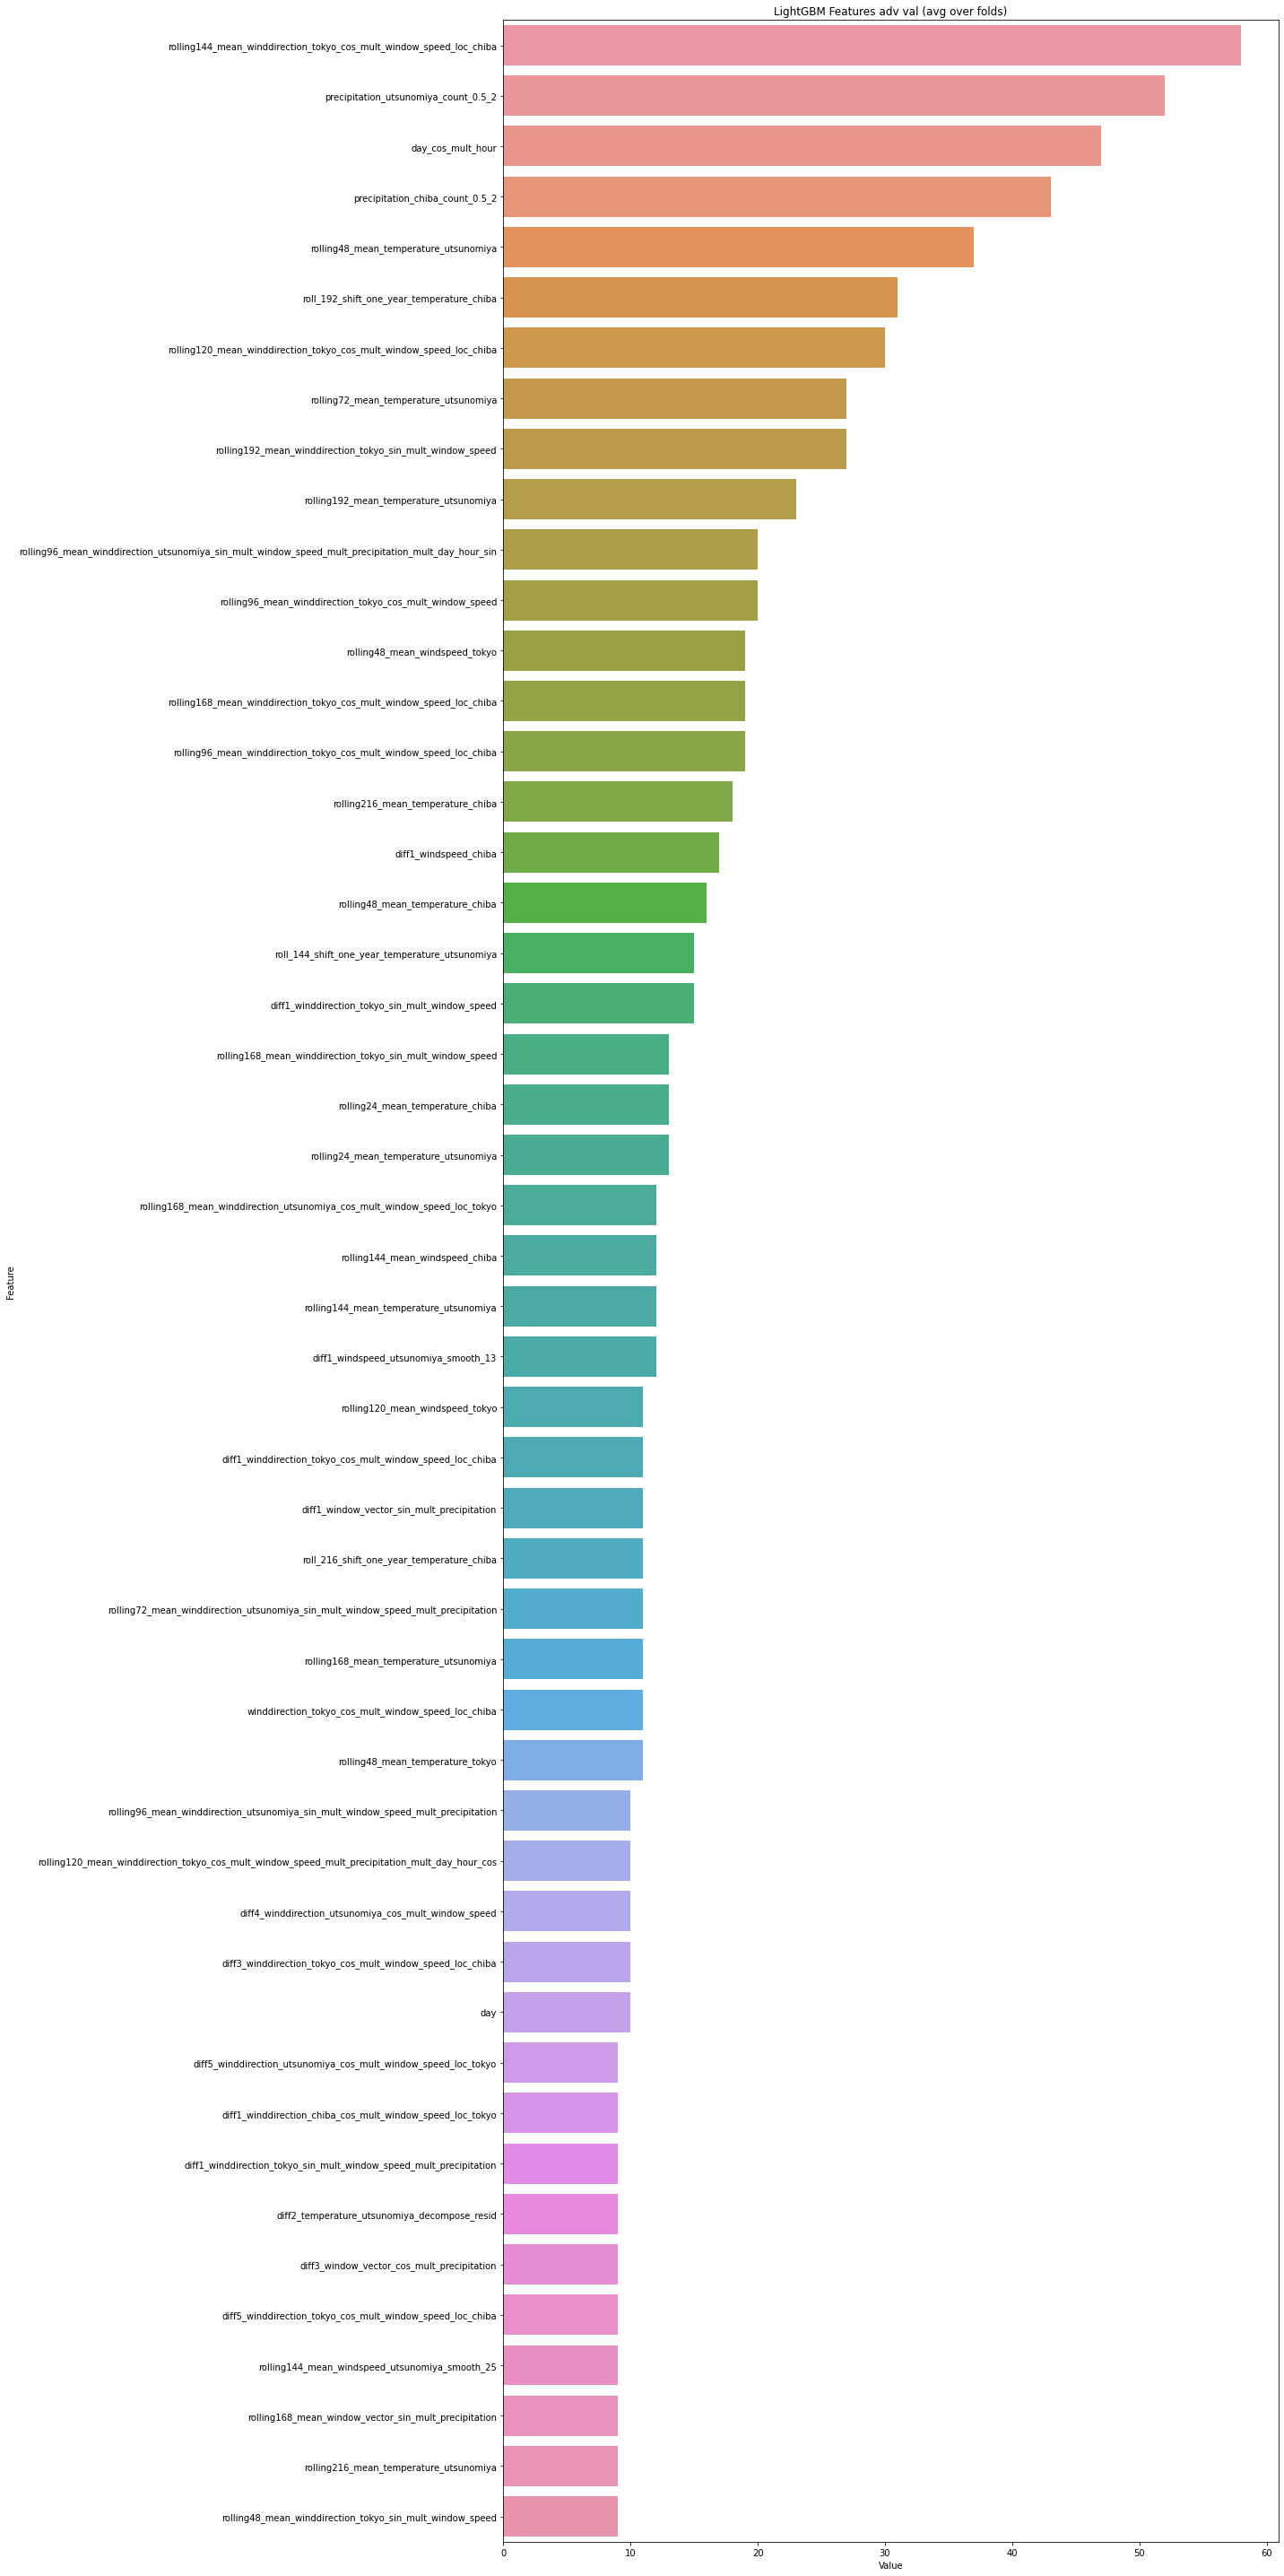

In [23]:
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

In [24]:
__df = _df.drop(["pollen_tokyo", "pollen_utsunomiya", "pollen_chiba"], axis=1)
__df_test = _df_test.drop(["pollen_tokyo", "pollen_utsunomiya", "pollen_chiba"], axis=1)
# df_adv = pd.concat([__df, __df_test])


__df_pos_1 = __df[
    (__df["datetime_dt"] >= datetime.datetime(2019, 4, 1))
    & (__df["datetime_dt"] < datetime.datetime(2019, 4, 14))
].reset_index(drop=True)

__df_pos_2 = __df[
    (__df["datetime_dt"] >= datetime.datetime(2018, 4, 1))
    & (__df["datetime_dt"] < datetime.datetime(2018, 4, 14))
].reset_index(drop=True)

__df_pos_3 = __df[
    (__df["datetime_dt"] >= datetime.datetime(2017, 4, 1))
    & (__df["datetime_dt"] < datetime.datetime(2017, 4, 14))
].reset_index(drop=True)


__df_pos_2020 = __df[
    (__df["datetime_dt"] >= datetime.datetime(2020, 1, 1))
].reset_index(drop=True)

__df_pos_2019 = __df[
    (__df["datetime_dt"] >= datetime.datetime(2019, 1, 1))
    & (__df["datetime_dt"] < datetime.datetime(2019, 4, 16))
].reset_index(drop=True)


#__df_pos = pd.concat([__df_pos_3, __df_pos_2, __df_pos_1])
__df_pos = __df_pos_2019
__df_test = pd.concat([__df_pos_2020, __df_test])

# __df_pos = __df[(__df["datetime_dt"] >=  datetime.datetime(2019, 4, 1))
#                  & (__df["datetime_dt"] < datetime.datetime(2019, 4, 14))].reset_index(drop=True)

df_adv = pd.concat([__df_pos, __df_test])
df_adv.head()


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,rolling216_mean_temperature_tokyo_decompose_resid,rolling216_mean_temperature_tokyo_decompose_minus_trend,rolling216_mean_temperature_utsunomiya_decompose_trend,rolling216_mean_temperature_utsunomiya_decompose_seasonal,rolling216_mean_temperature_utsunomiya_decompose_resid,rolling216_mean_temperature_utsunomiya_decompose_minus_trend,rolling216_mean_temperature_chiba_decompose_trend,rolling216_mean_temperature_chiba_decompose_seasonal,rolling216_mean_temperature_chiba_decompose_resid,rolling216_mean_temperature_chiba_decompose_minus_trend
0,2019020101,0.0,1.0,0.0,0.6,1.5,3.0,10.0,1,1,...,-6.880839,-12.869938,14.997010,-6.850622,-7.546388,-14.397010,16.048287,-5.502969,-9.045318,-14.548287
1,2019020102,0.0,0.0,0.0,0.7,1.6,2.7,11.0,2,1,...,-6.515824,-12.519347,14.469875,-6.788767,-7.031107,-13.819875,15.586006,-5.433442,-8.602564,-14.036006
2,2019020103,0.0,0.0,0.0,0.5,1.6,2.2,12.0,1,16,...,-6.243961,-12.235593,13.942601,-6.803483,-6.539118,-13.342601,15.123421,-5.269381,-8.287373,-13.556754
3,2019020104,0.0,0.0,0.0,-0.4,1.1,2.3,10.0,3,15,...,-5.845030,-11.820087,13.416630,-6.815534,-6.251096,-13.066630,14.661700,-5.183745,-8.027956,-13.211700
4,2019020105,0.0,0.0,0.0,-0.3,2.7,1.8,11.0,14,1,...,-5.504089,-11.474485,12.893771,-6.785992,-5.887779,-12.673771,14.202508,-5.082361,-7.420148,-12.502508


In [25]:
__df_pos_3.shape, __df_test.shape, __df_pos.shape

((312, 1884), (1776, 1884), (1775, 1884))

In [26]:
__df_pos.shape, __df_test.shape

((1775, 1884), (1776, 1884))

In [27]:
__df_pos.datetime_dt.max(), __df_pos.datetime_dt.min()

(Timestamp('2019-04-15 23:00:00'), Timestamp('2019-02-01 01:00:00'))

In [28]:
__df_test.datetime_dt.max(), __df_test.datetime_dt.min()

(Timestamp('2020-04-15 00:00:00'), Timestamp('2020-02-01 01:00:00'))

In [29]:
print('重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある')


df_adv["label"] = [1 for _ in range(len(__df_pos))] + [0 for _ in range(len(__df_test))]

# model = lgb.LGBMClassifier(n_jobs=-1, random_state=1)
# model.fit(df_adv[cols], [1 for _ in range(len(_df))] + [0 for _ in range(len(_df_test))] )

# lgbm_adv_importance = model.feature_importances_
# feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, cols)), columns=['Value','Feature'])

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

folds = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
es = early_stopping(1000)
le = log_evaluation(period=100)
scores = []  
dfs = []  

imps_list = [] 
    
for fold, (train_idx, val_idx) in enumerate(folds.split(df_adv[cols], df_adv[["label"]])):
    print(f"=====fold {fold}=======")

    df_train = df_adv.iloc[train_idx].reset_index(drop=True)
    df_val = df_adv.iloc[val_idx].reset_index(drop=True)
    
    print("train shape", df_train.shape, "test shape", df_val.shape)
    
    model = LGBMClassifier(random_state=42)
    
    model.fit(df_train[cols], df_train["label"],
            eval_set=(df_val[cols], df_val["label"]),
            callbacks=[es, le],
            eval_metric="auc"              
            )
    imps = model.feature_importances_
    imps_list.append(imps)
    # validation
    val_pred = model.predict(df_val[cols])
    val_score = roc_auc_score(df_val["label"], val_pred)
    scores.append(val_score)
    
    dfs.append(pd.DataFrame({"index": val_idx, "pred": val_pred}))


imps = np.mean(imps_list, axis=0)
df_imps = pd.DataFrame({"columns": df_adv[cols].columns.tolist(), "feat_imp": imps})
df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

df_pred = pd.concat(dfs)
df_pred.head()

重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある
=====fold 0=======
train shape (1775, 1885) test shape (1776, 1885)
Training until validation scores don't improve for 1000 rounds
[100]	valid_0's auc: 1	valid_0's binary_logloss: 7.38703e-05
Did not meet early stopping. Best iteration is:
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.407099
=====fold 1=======
train shape (1776, 1885) test shape (1775, 1885)
[100]	valid_0's auc: 1	valid_0's binary_logloss: 0.00415858
Did not meet early stopping. Best iteration is:
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.407099


,index,pred
0,0,1
1,3,1
2,4,1
3,6,1
4,7,1


In [30]:
df_adv[df_adv["label"] == 1].tail()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,rolling216_mean_temperature_tokyo_decompose_minus_trend,rolling216_mean_temperature_utsunomiya_decompose_trend,rolling216_mean_temperature_utsunomiya_decompose_seasonal,rolling216_mean_temperature_utsunomiya_decompose_resid,rolling216_mean_temperature_utsunomiya_decompose_minus_trend,rolling216_mean_temperature_chiba_decompose_trend,rolling216_mean_temperature_chiba_decompose_seasonal,rolling216_mean_temperature_chiba_decompose_resid,rolling216_mean_temperature_chiba_decompose_minus_trend,label
1770,2019041519,0.0,0.0,0.0,13.2,17.4,16.1,14.0,15,15,...,0.031110,9.888729,0.001940,0.031090,0.033030,11.676531,0.017905,0.016674,0.034580,1
1771,2019041520,0.0,0.0,0.0,11.5,15.9,14.2,12.0,15,15,...,0.023950,9.883317,-0.001955,0.030675,0.028720,11.677905,0.012359,0.022236,0.034595,1
1772,2019041521,0.0,0.0,0.0,11.3,14.8,13.6,3.0,15,13,...,0.020204,9.877751,-0.004845,0.029409,0.024564,11.679269,0.005151,0.025302,0.030453,1
1773,2019041522,0.0,0.0,0.0,10.4,14.4,12.2,1.0,15,16,...,0.010195,9.872074,-0.006198,0.027643,0.021445,11.680605,-0.000277,0.025228,0.024951,1
1774,2019041523,0.0,0.0,0.0,9.5,13.2,12.2,6.0,14,1,...,0.004156,9.866329,-0.007450,0.025381,0.017931,11.681885,-0.006650,0.021060,0.014411,1


In [31]:
df_adv[df_adv["label"] == 0].head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,rolling216_mean_temperature_tokyo_decompose_minus_trend,rolling216_mean_temperature_utsunomiya_decompose_trend,rolling216_mean_temperature_utsunomiya_decompose_seasonal,rolling216_mean_temperature_utsunomiya_decompose_resid,rolling216_mean_temperature_utsunomiya_decompose_minus_trend,rolling216_mean_temperature_chiba_decompose_trend,rolling216_mean_temperature_chiba_decompose_seasonal,rolling216_mean_temperature_chiba_decompose_resid,rolling216_mean_temperature_chiba_decompose_minus_trend,label
0,2020020101,0.0,0.0,0.0,0.0,6.7,1.8,10.0,14,1,...,-11.807117,12.552237,-5.068279,-7.483958,-12.552237,15.853633,-3.605974,-5.547659,-9.153633,0
1,2020020102,0.0,0.0,0.0,0.3,6.2,4.3,15.0,15,14,...,-10.296705,12.251266,-4.940149,-7.161117,-12.101266,15.562090,-3.721569,-5.390522,-9.112090,0
2,2020020103,0.0,0.0,0.0,-0.1,6.4,2.3,16.0,14,13,...,-10.286976,11.950193,-5.017406,-6.866121,-11.883527,15.270136,-3.728406,-5.108396,-8.836803,0
3,2020020104,0.0,0.0,0.0,-0.2,5.4,1.8,16.0,14,15,...,-10.277768,11.648891,-5.017526,-6.631365,-11.648891,14.978331,-3.803144,-5.000188,-8.803331,0
4,2020020105,0.0,0.0,0.0,-0.9,5.1,1.1,14.0,14,11,...,-10.309219,11.347603,-5.023325,-6.504278,-11.527603,14.687502,-3.904940,-4.822562,-8.727502,0


In [32]:
df_pred = df_pred.sort_values("index").reset_index(drop=True)

In [33]:
df_adv = pd.concat([df_adv, df_pred], axis=0)

In [34]:
#feature_imp

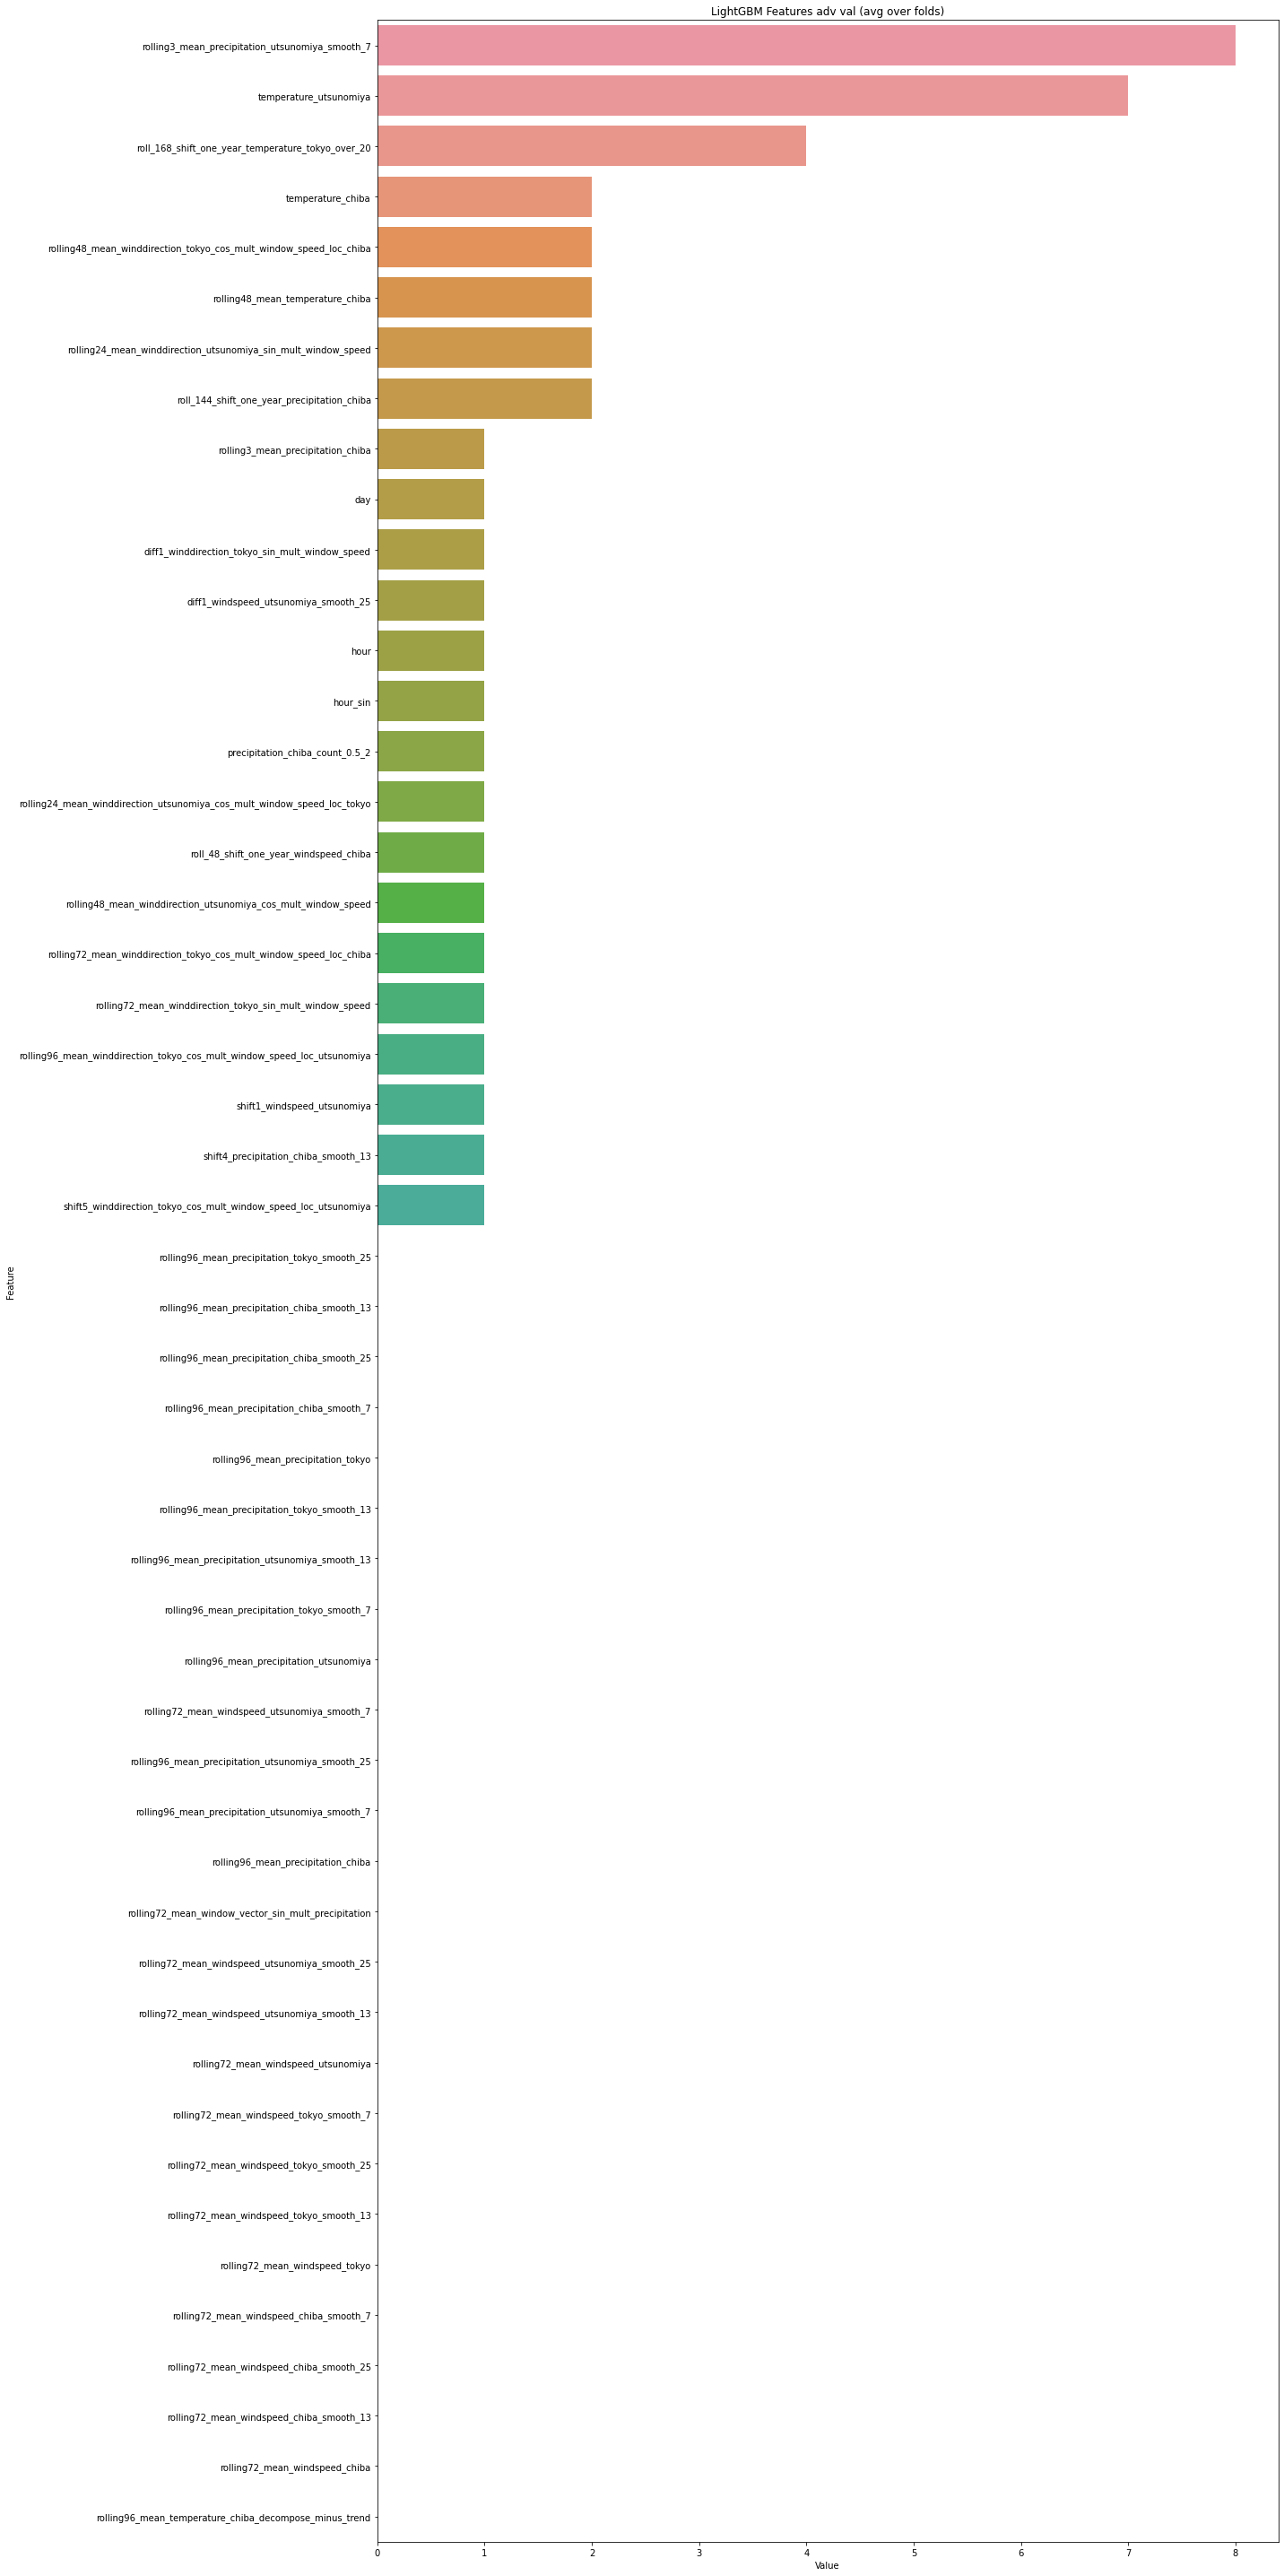

In [35]:
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, cols)), columns=['Value','Feature'])




plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()



# plt.figure(figsize=(10, 20))
# sns.barplot(x="fea_imp", y="columns", data=feature_imp.head(50))
# plt.title('LightGBM Features adv val (avg over folds)')
# plt.tight_layout()
# plt.show()

In [36]:
#pred = model.predict_proba(df_adv[cols])[:, 1]
#df_adv["pred"] = pred

In [37]:
df_adv[(df_adv["pred"] < 0.6) & (df_adv["datetime_dt"] <= datetime.datetime(2020, 1, 1))]

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,rolling216_mean_temperature_utsunomiya_decompose_seasonal,rolling216_mean_temperature_utsunomiya_decompose_resid,rolling216_mean_temperature_utsunomiya_decompose_minus_trend,rolling216_mean_temperature_chiba_decompose_trend,rolling216_mean_temperature_chiba_decompose_seasonal,rolling216_mean_temperature_chiba_decompose_resid,rolling216_mean_temperature_chiba_decompose_minus_trend,label,index,pred
